## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [2]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random


In [3]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [4]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

In [5]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    return text.upper()

shout("hello")

HELLO


'HELLO'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.




### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [38]:

class State(BaseModel):
        
    messages: Annotated[list, add_messages]


### Step 2: Start the Graph Builder with this State class

In [47]:
graph_builder = None
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [48]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("chatbot", our_first_node)
graph_builder.add_node("my_first_node", our_first_node)

### Step 4: Create Edges

In [49]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph_builder.add_edge(START, "my_first_node")
graph_builder.add_edge("my_first_node", END)

### Step 5: Compile the Graph

In [50]:
graph = graph_builder.compile()

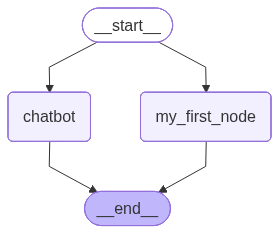

In [51]:
#from langchain_core.runnables.graph_mermaid import draw_mermaid_png,MermaidDrawMethod
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [ ]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

c:\dev\agents\.venv\Lib\site-packages\starlette\routing.py:138: RuntimeWarning: coroutine '_render_mermaid_using_pyppeteer' was never awaited
  duplicated_params = set()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='a12435e9-5ad4-4b2b-aa4c-301577071d1d'), AIMessage(content='Toasters are untrustworthy', additional_kwargs={}, response_metadata={}, id='2c24f706-7f44-45d3-a4ab-b6e277653146'), AIMessage(content='Toasters are untrustworthy', additional_kwargs={}, response_metadata={}, id='ba1dcdff-91a3-4d6e-a4a3-00f7762b4e82')]}
{'messages': [HumanMessage(content='what?', additional_kwargs={}, response_metadata={}, id='490fee64-a5d9-4c43-a44d-e42ac81c79b1'), AIMessage(content='Eels are squishy', additional_kwargs={}, response_metadata={}, id='ac54618f-9fac-431a-95f6-0b4abdd5c1d4'), AIMessage(content='Muffins are untrustworthy', additional_kwargs={}, response_metadata={}, id='f17a315f-f606-4eb3-b74f-f4e9c22a37d7')]}


### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [53]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [54]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)


In [55]:
# Step 3: Create a Node

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [56]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [59]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
#display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [60]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='247430c8-e4c0-4174-a76b-5b6c7b919afd'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CKpthcbzq6rUPBxxBD3UyuhzcsI3q', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e1c77709-2158-4d51-ac23-b717e5cc98f5-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [HumanMessage(content='my 